In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-04-20 10:37:40,914: Default instance: ibm-q/open/main


In [2]:
!pip install qiskit_machine_learning

  Using cached qiskit_machine_learning-0.7.2-py3-none-any.whl.metadata (12 kB)
  Using cached fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl
Using cached qiskit_machine_learning-0.7.2-py3-none-any.whl (97 kB)


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

algorithm_globals.random_seed = 42

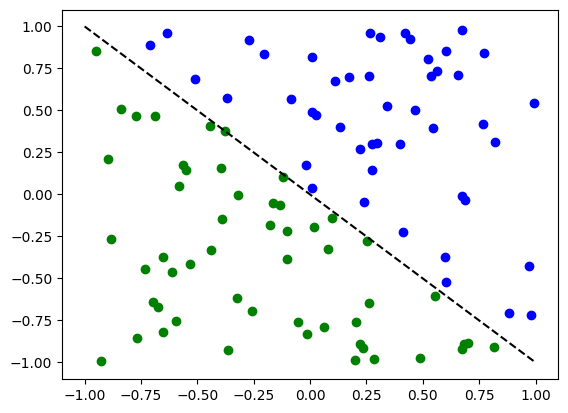

In [33]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 100

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for SamplerQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for EstimatorQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [5]:
import pandas as pd

df1 = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])
df1["Label"] = y
df2 = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])
df2["Label"] = y01

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
df1

,Feature 1,Feature 2,Label
0,0.547912,-0.122243,1
1,0.717196,0.394736,1
2,-0.811645,0.951245,1
3,0.522279,0.572129,1
4,-0.743773,-0.099228,-1
...,...,...,...
95,0.873626,-0.518059,1
96,-0.754484,0.662225,-1
97,-0.693431,-0.641463,-1
98,0.198766,0.749124,1


In [7]:
df2

,Feature 1,Feature 2,Label
0,0.547912,-0.122243,1
1,0.717196,0.394736,1
2,-0.811645,0.951245,1
3,0.522279,0.572129,1
4,-0.743773,-0.099228,0
...,...,...,...
95,0.873626,-0.518059,1
96,-0.754484,0.662225,0
97,-0.693431,-0.641463,0
98,0.198766,0.749124,1


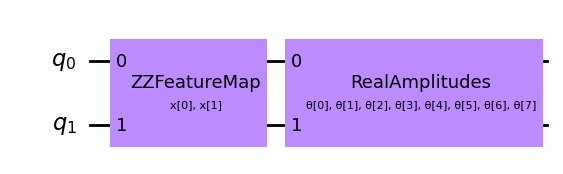

In [8]:
# Set up a circuit
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl", style="clifford", fold=-1)

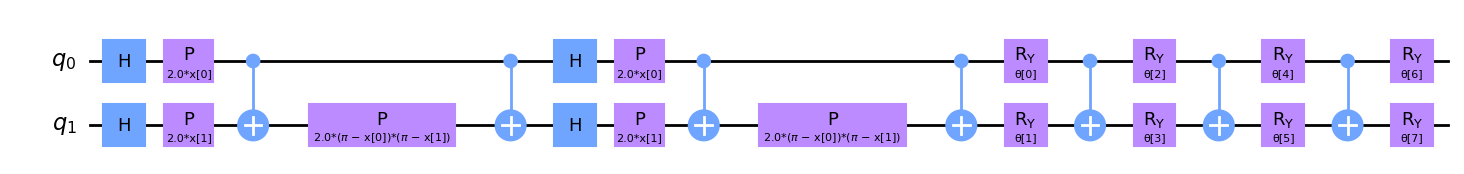

In [9]:
from qiskit import transpile
from qiskit.circuit.library.standard_gates import RXGate, RYGate, RZGate

qc_rxryrz = qc.decompose()

# Drawing the circuit
qc_rxryrz.draw(output="mpl", style="clifford", fold=-1)

In [10]:
# Setup QNN
qnn1 = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [ 0.05548097  0.09436529  0.00014824 -0.0712205  -0.09721274 -0.05406879
 -0.07363556  0.03553173]


In [11]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode

def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

99.59304809570312
94.38568878173828
92.97649383544922
92.42337036132812
91.9955062866211
91.79255676269531
91.73683166503906
91.73236083984375
91.73233032226562
91.7323226928711
91.73233032226562


tensor(99.5930, grad_fn=<MseLossBackward0>)

Accuracy: 0.63


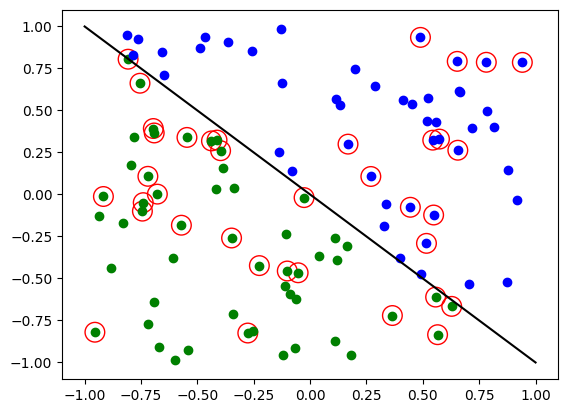

In [12]:
# Evaluate model and compute accuracy
model1.eval()
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=1)
plt.plot([-1, 1], [1, -1], "-", color="black")
plt.show()

In [28]:
# Define feature map and ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Define SamplerQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [ 0.07940668 -0.0942001  -0.05183439 -0.07139562]


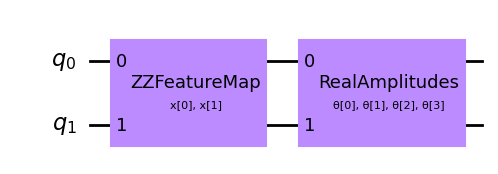

In [29]:
qc.draw(output="mpl", style="clifford", fold=-1)

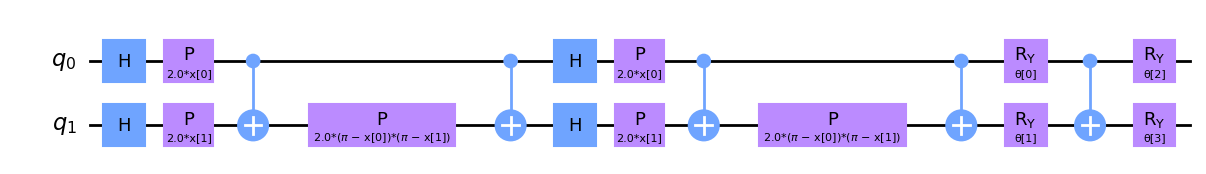

In [30]:
qc_rxryrz = qc.decompose()

# Drawing the circuit
qc_rxryrz.draw(output="mpl", style="clifford", fold=-1)                                                                                  

In [43]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

0.704220175743103
0.7039381265640259
0.6964554786682129
0.6933175921440125
0.6802778840065002
0.7225794792175293
0.7211639285087585
0.6844190359115601
0.6913087964057922
0.7601637244224548
0.7011452317237854
0.7194870710372925
0.7301124334335327
0.7244884371757507
0.7056334018707275
0.7354910373687744
0.7328219413757324
0.7399142384529114
0.7089365124702454
0.6955456733703613


Accuracy: 0.47


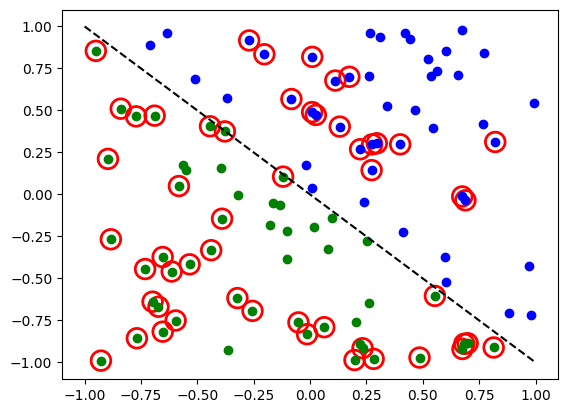

In [44]:
# Evaluate model and compute accuracy
model2.eval()
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

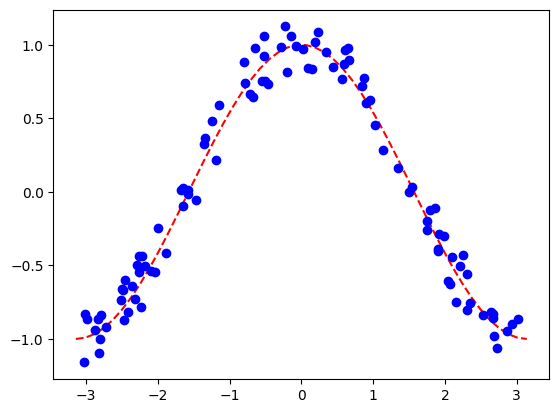

In [18]:
# Generate random dataset

num_samples = 100
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.cos(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

In [19]:
# Construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# Construct simple parameterized ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Construct QNN
qnn3 = EstimatorQNN(circuit=qc, input_params=[param_x], weight_params=[param_y])

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

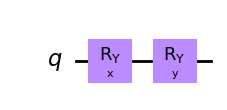

In [20]:
qc.draw(output="mpl", style="clifford", fold=-1)

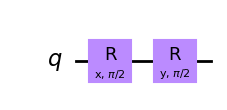

In [21]:
qc_expanded = qc.decompose()

# Drawing the circuit
qc_expanded.draw(output="mpl", style="clifford", fold=-1)

In [22]:
# Define optimizer and loss function
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model3.train()  # set model to training mode

# Define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)

1.7922966480255127
38.480159759521484
1.2654881477355957
1.2622928619384766
1.262263298034668


tensor(1.7923, grad_fn=<MseLossBackward0>)

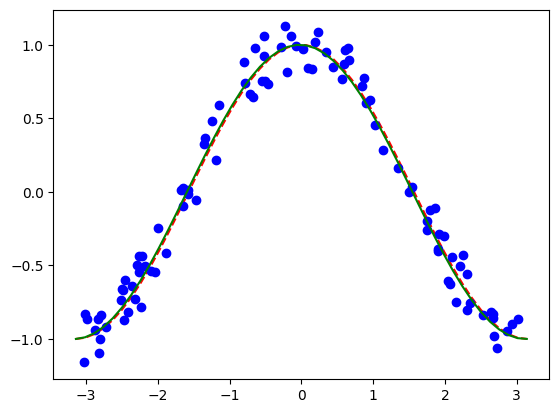

In [23]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot data
plt.plot(X, y, "bo")

# Plot fitted line
model3.eval()
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()